基于Ginzburg-Landau模型流场超分辨应用

# 封装常用函数

## 相对误差计算

用来计算输出和目标之间的相对误差

In [1]:
import numpy as np

def compute_relative_error(psi1_real_pre, psi1_imag_pre, psi1_tra_real, psi1_tar_imag):
    """
    计算输出和目标之间的相对误差

    参数:
    - psi1_real_pre: 预测的实部
    - psi1_imag_pre: 预测的虚部
    - psi1_tra_real: 目标的实部
    - psi1_tar_imag: 目标的虚部

    返回:
    - relative_error: 相对误差
    """
    # 计算误差
    error = np.sum((psi1_tra_real - psi1_real_pre) ** 2 + (psi1_tar_imag - psi1_imag_pre) ** 2)

    # 计算实际值的平方和（用来归一化误差）
    total_energy = np.sum(psi1_tra_real ** 2 + psi1_tar_imag ** 2)

    # 计算相对误差
    relative_error = error / total_energy

    return relative_error


##  计算速度场

In [2]:
import numpy as np

class VelocityFieldCalculator:
    def __init__(self, resx, resy, hbar, Npsi):
        self.resx = resx
        self.resy = resy
        self.hbar = hbar
        self.Npsi = Npsi

        # ix 和 iy 可以是用于索引的网格
        self.ix, self.iy = np.meshgrid(np.arange(resx), np.arange(resy), indexing='ij')
        self.ixp = (self.ix + 1) % resx  # 对应 MATLAB 中的 mod(ix, resx) + 1
        self.iyp = (self.iy + 1) % resy  # 对应 MATLAB 中的 mod(iy, resy) + 1

    def VelocityOneForm(self, psi):
        thetax = np.zeros((self.resx, self.resy), dtype=np.complex64)
        thetay = np.zeros((self.resx, self.resy), dtype=np.complex64)

        for ii in range(self.Npsi):
            # 这里要确保 psi[self.ixp, :, ii] 的结果形状与 thetax 匹配
            thetax += np.conj(psi[:, :, ii]) * psi[self.ixp[:,0], :, ii]
            thetay += np.conj(psi[:, :, ii]) * psi[:, self.iyp[0,:], ii]

        vx = self.hbar * np.angle(thetax)
        vy = self.hbar * np.angle(thetay)

        return vx, vy


## 定义绘图类

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline

# 定义Animator类和其他辅助函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats("svg")

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(
        self,
        xlabels=[None, None],
        ylabels=[None, None],
        legends=[None, None],
        xlims=[None, None],
        ylims=[None, None],
        xscales=["linear", "linear"],
        yscales=["linear", "linear"],
        fmts=["c--", "m", "g--", "r"],
        nrows=1,
        ncols=2,
        figsize=(10, 4),
    ):
        use_svg_display()
        if legends is None:
            legends = [[], []]
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.config_axes = lambda: (
            set_axes(
                self.axes[0],
                xlabels[0],
                ylabels[0],
                xlims[0],
                ylims[0],
                xscales[0],
                yscales[0],
                legends[0],
            ),
            set_axes(
                self.axes[1],
                xlabels[1],
                ylabels[1],
                xlims[1],
                ylims[1],
                xscales[1],
                yscales[1],
                legends[1],
            ),
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[1].cla()
        for i, (x, y, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if i < 2:
                self.axes[0].plot(x, y, fmt)
            else:
                self.axes[1].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


## 下采样函数1

In [4]:
# 下采样函数
def downsample(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)
    return low_res_input

## 下采样函数$downsample\_\psi2$

In [5]:
def downsample_psi2(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi2_real_low_res, psi2_imag_low_res], dim=1)
    return low_res_input


## 下采样函数$downsample\_i$

其中$i=4, 8, 16$

In [6]:
def downsample_4(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    # low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)

    return psi1_real_low_res, psi1_imag_low_res, psi2_real_low_res, psi2_imag_low_res, ux_low_res, uy_low_res



def downsample_8(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=8, stride=8)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    # low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)

    return psi1_real_low_res, psi1_imag_low_res, psi2_real_low_res, psi2_imag_low_res, ux_low_res, uy_low_res


def downsample_16(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=16, stride=16)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    # low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)

    return psi1_real_low_res, psi1_imag_low_res, psi2_real_low_res, psi2_imag_low_res, ux_low_res, uy_low_res


# 读取原始数据

In [7]:
import scipy.io as sio
import torch


In [8]:

# 读取速度场数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32)

# 读取波函数数据
wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 读取误差场数据
error_field_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/error_field.mat')
vx_error0 = torch.tensor(error_field_data['vx_error'], dtype=torch.float32)
vy_error0 = torch.tensor(error_field_data['vy_error'], dtype=torch.float32)

# 打印数据形状以确认
print(f'ux shape: {ux0.shape}')
print(f'uy shape: {uy0.shape}')
print(f'psi1 shape: {psi1_0.shape}')
print(f'psi2 shape: {psi2_0.shape}')
print(f'vx_error shape: {vx_error0.shape}')
print(f'vy_error shape: {vy_error0.shape}')


ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# 深度学习超分辨

### 波函数超分辨

#### 下采样数据

In [10]:
import scipy.io as sio
import torch


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio

# 读取数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 分别提取实部和虚部，并添加通道维度
psi1_real = psi1_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi1_imag = psi1_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_real = psi2_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_imag = psi2_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

print(f'ux0 shape: {ux0.shape}')
print(f'uy0 shape: {uy0.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')


ux0 shape: torch.Size([1, 1, 512, 512])
uy0 shape: torch.Size([1, 1, 512, 512])
psi1_real shape: torch.Size([1, 1, 512, 512])
psi1_imag shape: torch.Size([1, 1, 512, 512])
psi2_real shape: torch.Size([1, 1, 512, 512])
psi2_imag shape: torch.Size([1, 1, 512, 512])


#### 划分验证集

In [13]:
# 生成验证集
def split_data(tensor, val_ratio=0.2):
    train_size = int((1 - val_ratio) * tensor.shape[-1])-1
    train_tensor, val_tensor = torch.split(tensor, [train_size, tensor.shape[-1] - train_size], dim=-1)
    return train_tensor, val_tensor


In [14]:
# 分割训练集和验证集
ux0_train, ux0_val = split_data(ux0)
uy0_train, uy0_val = split_data(uy0)
psi1_real_train, psi1_real_val = split_data(psi1_real)
psi1_imag_train, psi1_imag_val = split_data(psi1_imag)
psi2_real_train, psi2_real_val = split_data(psi2_real)
psi2_imag_train, psi2_imag_val = split_data(psi2_imag)

print(f'ux_train shape: {ux0_train.shape}')
print(f'ux_val shape: {ux0_val.shape}')
print(f'psi1_real_train shape: {psi1_real_train.shape}')
print(f'psi1_real_val shape: {psi1_real_val.shape}')
print(f'psi2_imag_train shape: {psi2_imag_train.shape}')
print(f'psi2_imag_val shape: {psi2_imag_val.shape}')


ux_train shape: torch.Size([1, 1, 512, 408])
ux_val shape: torch.Size([1, 1, 512, 104])
psi1_real_train shape: torch.Size([1, 1, 512, 408])
psi1_real_val shape: torch.Size([1, 1, 512, 104])
psi2_imag_train shape: torch.Size([1, 1, 512, 408])
psi2_imag_val shape: torch.Size([1, 1, 512, 104])


#### 定义模型

In [15]:
# 模型定义
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 上采样（从128x128到256x256）
        self.upconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu4 = nn.ReLU()

        # 上采样（从256x256到512x512）
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))

        x = self.relu4(self.upconv1(x))  # 第一次上采样
        x = self.upconv2(x)  # 第二次上采样

        return x


In [16]:
# 数据预处理
low_res_input_train = downsample(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)

low_res_input_train.shape, low_res_input_val.shape


(torch.Size([1, 2, 128, 102]), torch.Size([1, 2, 128, 26]))

#### 模型初始化及参数

In [17]:

model = SuperResolutionCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-4)

# 训练循环
model.train()
epochs = 20000


In [18]:
# model.train()
# epochs = 20000

# animator = Animator(
#     xlabels=["epoch", "epoch"],
#     ylabels=["Loss", "Metric"],
#     legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
#     xlims=[[1, epochs], [1, epochs]],
#     ylims=[[0, 10], [0, 10]]
# )


# for epoch in range(epochs):
#     optimizer.zero_grad()

#     # 将输入传递给模型
#     output_train = model(low_res_input_train.to(device))

#     # 计算损失
#     target_train  = torch.cat([psi1_real_train, psi1_imag_train], dim=1).to(device)  # 目标是高分辨率的 ux 和 uy
#     loss_train = 10000*criterion(output_train, target_train)

#     # 反向传播和优化
#     loss_train.backward()
#     optimizer.step()


#     model.eval()
#     with torch.no_grad():
#         output_val = model(low_res_input_val.to(device))
#         target_val = torch.cat([psi1_real_val, psi1_imag_val], dim=1).to(device)
#         loss_val = criterion(output_val, target_val)*2000


#     model.train() 
#     print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')
device

device(type='cuda')

#### 训练

In [19]:
# # 初始化Animator，用于绘制训练过程中的loss和metric变化曲线
# animator = Animator(
#     xlabels=["epoch", "epoch"],
#     ylabels=["Loss", "Metric"],
#     legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
#     xlims=[[1, epochs], [1, epochs]],
#     ylims=[[0, 0.1], [0, 100]],  # 可根据实际损失范围调整
# )

# for epoch in range(epochs):
#     optimizer.zero_grad()

#     # 将输入传递给模型
#     output_train = model(low_res_input_train.to(device))

#     # 计算训练损失
#     target_train = torch.cat([psi1_real_train, psi1_imag_train], dim=1).to(device)  # 目标是高分辨率的 ux 和 uy
#     loss_train = 1000 * criterion(output_train, target_train)

#     # 反向传播和优化
#     loss_train.backward()
#     optimizer.step()

#     # 验证集上的性能评估
#     model.eval()  # 设置模型为评估模式
#     with torch.no_grad():
#         output_val = model(low_res_input_val.to(device))
#         target_val = torch.cat([psi1_real_val, psi1_imag_val], dim=1).to(device)
#         loss_val = criterion(output_val, target_val)*2000
    
#     # 获取指标
#     # 在这里你可以根据需要定义并计算 "metric" (例如 PSNR, SSIM, etc.)
#     train_metric = loss_train.item()  # 示例：这里暂时用 loss 作为 metric
#     val_metric = loss_val.item()  # 示例：这里暂时用 loss 作为 metric

#     # 动态绘制训练过程
#     # 两个子图的更新: 训练损失 vs 验证损失 以及 训练度量 vs 验证度量
#     animator.add(epoch + 1, [loss_train.item(), loss_val.item()])  # 更新损失
#     animator.add(epoch + 1, [train_metric, val_metric])            # 更新度量

#     # 恢复模型为训练模式
#     model.train()

#     # 打印当前epoch的训练和验证损失
#     if (epoch + 1) % 100 == 0 or epoch == 0:
#         print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')


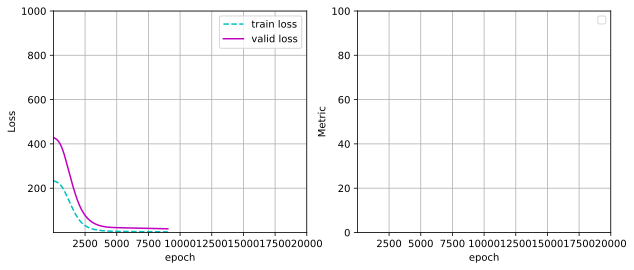

In [20]:
import matplotlib.pyplot as plt

# 初始化Animator，使用对数y轴
animator = Animator(
    xlabels=["epoch", "epoch"],
    ylabels=["Loss", "Metric"],
    legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
    xlims=[[1, epochs], [1, epochs]],
    ylims=[[0.001, 1000], [0, 100]]  # y轴初始范围，不能设置为0，设置为接近最小值
)

# 将y轴设置为对数坐标
animator.axes[0].set_yscale('log')  # 对训练损失的图像使用对数y轴

for epoch in range(epochs):
    optimizer.zero_grad()

    # 将输入传递给模型
    output_train = model(low_res_input_train.to(device))

    # 计算训练损失
    target_train = torch.cat([psi1_real_train, psi1_imag_train], dim=1).to(device)
    loss_train = 1000 * criterion(output_train, target_train)

    # 反向传播和优化
    loss_train.backward()
    optimizer.step()

    # 验证集上的性能评估
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        output_val = model(low_res_input_val.to(device))
        target_val = torch.cat([psi1_real_val, psi1_imag_val], dim=1).to(device)
        loss_val = criterion(output_val, target_val) * 2000
    
    # 获取指标
    train_metric = loss_train.item()
    val_metric = loss_val.item()

    # 动态绘制训练过程
    animator.add(epoch + 1, [loss_train.item(), loss_val.item()])  # 更新损失
    animator.add(epoch + 1, [train_metric, val_metric])            # 更新度量

    # 恢复模型为训练模式
    model.train()

    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')


#### 可视化

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(target_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')


plt.subplot(2,3,2)
plt.imshow(output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(target_train[0,0,:,:].detach().cpu().numpy() - output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(target_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(target_train[0,1,:,:].detach().cpu().numpy() - output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


In [ ]:
import numpy as np
output_train_img_part = output_train[0, 1, :, :].detach().cpu().numpy()
output_val_img_part = output_val[0, 1, :, :].detach().cpu().numpy()

output_train_real_part = output_train[0, 0, :, :].detach().cpu().numpy()
output_val_real_part = output_val[0, 0, :, :].detach().cpu().numpy()


psi1_pre_img  = np.concatenate((output_train_img_part, output_val_img_part), axis=1)
psi1_pre_real = np.concatenate((output_train_real_part, output_val_real_part), axis=1)


output_psi1_train_img_part = target_train[0, 1, :, :].detach().cpu().numpy()
output_psi1_val_img_part = target_val[0, 1, :, :].detach().cpu().numpy()


output_psi1_train_real_part = target_train[0, 0, :, :].detach().cpu().numpy()
output_psi1_val_real_part = target_val[0, 0, :, :].detach().cpu().numpy()


psi1_tar_img  = np.concatenate((output_psi1_train_img_part, output_psi1_val_img_part), axis=1)
psi1_tar_real = np.concatenate((output_psi1_train_real_part, output_psi1_val_real_part), axis=1)


In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(psi1_tar_real)
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(2,3,2)
plt.imshow(psi1_pre_real)
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(psi1_tar_real - psi1_pre_real)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(psi1_tar_img)
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(psi1_pre_img)
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(psi1_tar_img - psi1_pre_img)
plt.colorbar()
plt.title('Difference')

plt.show()



In [ ]:
low_res_input_train = downsample_psi2(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample_psi2(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)

#### 上述模型用$\psi_1$进行的训练和验证

psi_Net 使用的输入是两个通道的，即分别是$\psi_1$的实部，以及$\psi_1$的虚部

接下来，将使用$\psi_2$进行测试

In [ ]:
input_psi2 = np.concatenate((low_res_input_train, low_res_input_val), axis=3)

input_psi2_tensor = torch.tensor(input_psi2, dtype=torch.float32)

In [ ]:
model.eval()
with torch.no_grad():
    output_psi2 = model(input_psi2_tensor.to(device))  # 输出形状为 (1, 4, 512, 512)


In [ ]:
psi2_pred_real = output_psi2[0, 0, :, :].detach().cpu().numpy()
psi2_pred_imag = output_psi2[0, 1, :, :].detach().cpu().numpy()

psi2_tar_real = psi2_real[0, 0, :, :].detach().cpu().numpy()
psi2_tar_imag = psi2_imag[0, 0, :, :].detach().cpu().numpy()



In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(psi2_tar_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$True\ \psi_2\ real$')

plt.subplot(2,3,2)
plt.imshow(psi2_pred_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$Predicted\ \psi_2\ real$')

plt.subplot(2,3,3)
plt.imshow(psi2_tar_real - psi2_pred_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(psi2_tar_imag,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$True\ \psi_2\ imag$')

plt.subplot(2,3,5)
plt.imshow(psi2_pred_imag,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$Predicted\ \psi_2\ imag$')

plt.subplot(2,3,6)
plt.imshow(psi2_tar_imag - psi2_pred_imag,vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.title('Difference')


### 计算速度

In [ ]:
resx, resy = 512, 512  # 示例分辨率
hbar = 1.0  # 这里假设 hbar = 1
Npsi = 2  # 假设有两个波函数

In [ ]:
psi1_pre = psi1_pre_real + 1j * psi1_pre_img
psi2_pre = psi2_pred_real + 1j * psi2_pred_imag

psi1_tar = psi1_tar_real + 1j * psi1_tar_img
psi2_tar = psi2_tar_real + 1j * psi2_tar_imag


#### 计算$\psi$相对误差


In [ ]:
relative_error = compute_relative_error(psi1_pre_real, psi1_pre_img, psi1_tar_real, psi1_tar_img)
print(f'相对误差: {relative_error}')


####  计算速度场场

In [ ]:
psi_pre_combined = np.stack((psi1_pre, psi2_pre), axis=-1)

psi_tar_combined = np.stack((psi1_tar, psi2_tar), axis=-1)


In [ ]:
velocity_calculator = VelocityFieldCalculator(resx, resy, hbar, Npsi)

vx_pre, vy_pre = velocity_calculator.VelocityOneForm(psi_pre_combined)

vx_tar, vy_tar = velocity_calculator.VelocityOneForm(psi_tar_combined)

vx_pre.shape, vy_pre.shape

#### 可视化

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(vx_tar)
plt.colorbar()
plt.title('$True\ vx$')

plt.subplot(2,3,2)
plt.imshow(vx_pre,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.title('$Predicted\ vx$')

plt.subplot(2,3,3)
plt.imshow(vx_tar - vx_pre)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(vy_tar)
plt.colorbar()
plt.title('$True\ vy$')

plt.subplot(2,3,5)
plt.imshow(vy_pre,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.title('$Predicted\ vy$')

plt.subplot(2,3,6)
plt.imshow(vy_tar - vy_pre, vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference')

plt.show()

#### 计算速度场相对误差

In [ ]:
relative_error = compute_relative_error(vx_pre, vy_pre, vx_tar, vy_tar)
print(f'相对误差: {relative_error}')


### 误差超分辨

截至目前，我们有了如下的参数：



`psi1_pre_real, psi1_pre_img`: 预测$\psi_1$的实部和虚部

`psi2_pred_real, psi2_pred_imag`: 预测$\psi_2$的实部和虚部


`psi1_tar_real, psi1_tar_img`:真实$\psi_1$的实部和虚部

`psi2_tar_real, psi2_tar_imag`:真实$\psi_2$的实部和虚部

`vx_tar, vy_tar`: 分别为真实的`x,  y` 方向的速度场

`vx_pre, vy_pre`:根据预测的$\psi$计算出来的速度场




In [ ]:
vx_error0 = torch.tensor(error_field_data['vx_error'], dtype=torch.float32)
vy_error0 = torch.tensor(error_field_data['vy_error'], dtype=torch.float32)

In [ ]:
vx_error = vx_error0.detach().cpu().numpy()
vy_error = vy_error0.detach().cpu().numpy()

vx_tar_0 = vx_tar + vx_error*10
vy_tar_0 = vy_tar + vy_error*10

vx_pre_1 = vx_pre + vx_error*10
vy_pre_1 = vy_pre + vy_error*10

#### 可视化

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(2,3,1)
plt.imshow(vx_tar_0)
plt.colorbar()
plt.title('$True\ vx$')

plt.subplot(2,3,2)
plt.imshow(vx_pre_1,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.title('$Predicted\ vx$')

plt.subplot(2,3,3)
plt.imshow(vx_tar_0 - vx_pre_1, vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(vy_tar_0)
plt.colorbar()
plt.title('$True\ vy$')

plt.subplot(2,3,5)
plt.imshow(vy_pre_1,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.title('$Predicted\ vy$')

plt.subplot(2,3,6)
plt.imshow(vy_tar_0 - vy_pre_1, vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 设置全局字体和字号
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14

# 设置图像大小
plt.figure(figsize=(16, 10))

def plot_with_colorbar(ax, data, vmin, vmax, title, xlabel=None, ylabel=None, cmap='viridis'):
    """
    绘制带有自定义美化colorbar的图像
    """
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # 调整colorbar大小
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=12)  # 设置colorbar刻度字号
    ax.set_title(title, fontsize=16)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=14)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14)

# True vx
ax1 = plt.subplot(2, 3, 1)
plot_with_colorbar(ax1, vx_tar_0, vmin=-0.1, vmax=0.1, title=r'True $v_x$', xlabel='X', ylabel='Y')

# Predicted vx
ax2 = plt.subplot(2, 3, 2)
plot_with_colorbar(ax2, vx_pre_1, vmin=-0.1, vmax=0.1, title=r'Predicted $v_x$', xlabel='X')

# Difference in vx
ax3 = plt.subplot(2, 3, 3)
plot_with_colorbar(ax3, vx_tar_0 - vx_pre_1, vmin=-0.01, vmax=0.01, title=r'Difference ($v_x$)', xlabel='X', cmap='coolwarm')

# True vy
ax4 = plt.subplot(2, 3, 4)
plot_with_colorbar(ax4, vy_tar_0, vmin=-0.1, vmax=0.1, title=r'True $v_y$', xlabel='X', ylabel='Y')

# Predicted vy
ax5 = plt.subplot(2, 3, 5)
plot_with_colorbar(ax5, vy_pre_1, vmin=-0.1, vmax=0.1, title=r'Predicted $v_y$', xlabel='X')

# Difference in vy
ax6 = plt.subplot(2, 3, 6)
plot_with_colorbar(ax6, vy_tar_0 - vy_pre_1, vmin=-0.01, vmax=0.01, title=r'Difference ($v_y$)', xlabel='X', cmap='coolwarm')

# 调整布局，避免标题和图像重叠
plt.tight_layout()

# 显示图像
plt.show()


#### 计算误差

In [ ]:
relative_error = compute_relative_error(vx_pre_1, vy_pre_1, vx_tar_0, vy_tar_0)
print(f'相对误差: {relative_error}')


# 传统超分辨算法

## bicubic_4 算法

#### 下采样
downsample_2 函数进行4倍数下采样，将512————>128

kernel_size=4, stride=4

In [ ]:
_, _, _, _, ux0_low_4_res, uy0_low_4_res = downsample_4(ux0, uy0, psi1_real, psi1_imag, psi2_real, psi2_imag)


In [ ]:
ux0_low_res = ux0_low_4_res[0,0,:,:].squeeze(0).squeeze(0) 
uy0_low_res = uy0_low_4_res[0,0,:,:].squeeze(0).squeeze(0)

ux0_low_res.shape

In [ ]:
plt.imshow(ux0_low_res)

#### 使用bicubic进行超分

In [ ]:
import torch.nn.functional as F
ux0_high_4_res = F.interpolate(ux0_low_4_res[0,0].unsqueeze(0).unsqueeze(0), scale_factor=4, mode='bicubic').squeeze(0).squeeze(0)
uy0_high_4_res = F.interpolate(uy0_low_4_res[0,0].unsqueeze(0).unsqueeze(0), scale_factor=4, mode='bicubic').squeeze(0).squeeze(0)

#### 结果可视化

In [ ]:
plt.figure(figsize=(16, 10))

# Plot High resolution ux
plt.subplot(1, 3, 1)
im1 = plt.imshow(ux0_high_4_res, interpolation="None")
plt.colorbar(im1, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('High resolution $u_x$')

# Plot Original ux
plt.subplot(1, 3, 2)
im2 = plt.imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im2, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Original $u_x$')

# Plot Difference
plt.subplot(1, 3, 3)
im3 = plt.imshow(ux0_high_4_res - ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im3, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Difference')

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


In [ ]:
relative_4_error = compute_relative_error(ux0_high_4_res.detach().cpu().numpy(), uy0_high_4_res.detach().cpu().numpy(), ux0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy(), uy0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy())
print(f'相对误差: {relative_4_error}')


## bicubic_8 算法

In [ ]:
_, _, _, _, ux0_low_8_res, uy0_low_8_res = downsample_8(ux0, uy0, psi1_real, psi1_imag, psi2_real, psi2_imag)


In [ ]:
ux0_low_8_res = ux0_low_8_res[0,0,:,:].squeeze(0).squeeze(0) 
uy0_low_8_res = uy0_low_8_res[0,0,:,:].squeeze(0).squeeze(0)

ux0_low_8_res.shape

In [ ]:
plt.imshow(ux0_low_8_res)

#### 使用bicubic进行超分

In [ ]:
ux0_low_8_res.shape

In [ ]:
import torch.nn.functional as F
ux0_high_8_res = F.interpolate(ux0_low_8_res.unsqueeze(0).unsqueeze(0), scale_factor=8, mode='bicubic').squeeze(0).squeeze(0)
uy0_high_8_res = F.interpolate(uy0_low_8_res.unsqueeze(0).unsqueeze(0), scale_factor=8, mode='bicubic').squeeze(0).squeeze(0)

#### 结果可视化

In [ ]:
plt.figure(figsize=(16, 10))

# Plot High resolution ux
plt.subplot(1, 3, 1)
im1 = plt.imshow(ux0_high_8_res, interpolation="None")
plt.colorbar(im1, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('High resolution $u_x$')

# Plot Original ux
plt.subplot(1, 3, 2)
im2 = plt.imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im2, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Original $u_x$')

# Plot Difference
plt.subplot(1, 3, 3)
im3 = plt.imshow(ux0_high_8_res - ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im3, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Difference')

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


In [ ]:
relative_8_error = compute_relative_error(ux0_high_8_res.detach().cpu().numpy(), uy0_high_8_res.detach().cpu().numpy(), ux0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy(), uy0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy())
print(f'相对误差: {relative_8_error}')


## bicubic_16 算法

In [ ]:
_, _, _, _, ux0_low_16_res, uy0_low_16_res = downsample_16(ux0, uy0, psi1_real, psi1_imag, psi2_real, psi2_imag)
ux0_low_16_res.shape

In [ ]:
ux0_low_16_res = ux0_low_16_res[0,0,:,:].squeeze(0).squeeze(0) 
uy0_low_16_res = uy0_low_16_res[0,0,:,:].squeeze(0).squeeze(0)

ux0_low_16_res.shape

In [ ]:
plt.imshow(ux0_low_16_res)

#### 使用bicubic进行超分

In [ ]:
ux0_low_16_res.shape

In [ ]:
import torch.nn.functional as F
ux0_high_16_res = F.interpolate(ux0_low_16_res.unsqueeze(0).unsqueeze(0), scale_factor=16, mode='bicubic').squeeze(0).squeeze(0)
uy0_high_16_res = F.interpolate(uy0_low_16_res.unsqueeze(0).unsqueeze(0), scale_factor=16, mode='bicubic').squeeze(0).squeeze(0)

#### 结果可视化

In [ ]:
plt.figure(figsize=(16, 10))

# Plot High resolution ux
plt.subplot(1, 3, 1)
im1 = plt.imshow(ux0_high_16_res, interpolation="None")
plt.colorbar(im1, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('High resolution $u_x$')

# Plot Original ux
plt.subplot(1, 3, 2)
im2 = plt.imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im2, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Original $u_x$')

# Plot Difference
plt.subplot(1, 3, 3)
im3 = plt.imshow(ux0_high_16_res - ux0[0, 0, :, :].squeeze(0).squeeze(0), interpolation="None")
plt.colorbar(im3, shrink=0.4, pad=0.02)  # Adjust the colorbar size and distance
plt.title('Difference')

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


In [ ]:
relative_16_error = compute_relative_error(ux0_high_16_res.detach().cpu().numpy(), uy0_high_16_res.detach().cpu().numpy(), ux0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy(), uy0[0,0,:,:].squeeze(0).squeeze(0).detach().cpu().numpy())
print(f'相对误差: {relative_16_error}')

# 结果对比

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个24x15的图像
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# 定义共享的norm和colorbar的上下界
vmin = -0.01
vmax = 0.01

# 定义字体大小
title_fontsize = 15
label_fontsize = 16

# 设置刻度线方向的函数
def set_ticks_in(ax):
    ax.tick_params(direction='in', length=3, width=1)  # 设置刻度线向内，长度和宽度可以根据需要调整


# 绘制第一行子图
axes[0, 0].imshow(ux0_low_4_res[0, 0], vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Input $(\\times 4)$', fontsize=title_fontsize)
axes[0, 0].grid(False)  # 关闭网格线

axes[0, 1].imshow(ux0_high_4_res, vmin=vmin, vmax=vmax)
axes[0, 1].set_title('Bicubic $(\\times 4)$', fontsize=title_fontsize)

axes[0, 2].imshow(vx_pre_1 / 10, vmin=vmin, vmax=vmax)
axes[0, 2].set_title('Ours', fontsize=title_fontsize)

axes[0, 3].imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), vmin=vmin, vmax=vmax)
axes[0, 3].set_title('Target', fontsize=title_fontsize)

# 绘制第二行子图
axes[1, 0].imshow(ux0_low_8_res, vmin=vmin, vmax=vmax)
axes[1, 0].set_title('Input $(\\times 8)$', fontsize=title_fontsize)

axes[1, 1].imshow(ux0_high_8_res, vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Bicubic $(\\times 8)$', fontsize=title_fontsize)

axes[1, 2].imshow(vx_pre_1 / 10, vmin=vmin, vmax=vmax)
axes[1, 2].set_title('Ours', fontsize=title_fontsize)

axes[1, 3].imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), vmin=vmin, vmax=vmax)
axes[1, 3].set_title('Target', fontsize=title_fontsize)

# 绘制第三行子图
axes[2, 0].imshow(ux0_low_16_res, vmin=vmin, vmax=vmax)
axes[2, 0].set_title('Input $(\\times 16)$', fontsize=title_fontsize)

axes[2, 1].imshow(ux0_high_16_res, vmin=vmin, vmax=vmax)
axes[2, 1].set_title('Bicubic $(\\times 16)$', fontsize=title_fontsize)

axes[2, 2].imshow(vx_pre_1 / 10, vmin=vmin, vmax=vmax)
axes[2, 2].set_title('Ours', fontsize=title_fontsize)

axes[2, 3].imshow(ux0[0, 0, :, :].squeeze(0).squeeze(0), vmin=vmin, vmax=vmax)
axes[2, 3].set_title('Target', fontsize=title_fontsize)

# # 添加统一的 colorbar
# # 添加统一的 colorbar
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
#                     ax=axes, orientation='horizontal', fraction=0.1, pad=-10, shrink=0.18)
# cbar.set_label('Value', fontsize=label_fontsize)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.20, hspace=0.25)


for i in range(3):
    axes[i, 0].set_ylabel(r'Position ($\mathit{x}$)', fontsize=label_fontsize, fontname='Times New Roman')

for j in range(4):
    axes[2, j].set_xlabel(r'Position ($\mathit{x}$)', fontsize=label_fontsize, fontname='Times New Roman')


# 增加 (a), (b), (c) 等标注
for i, ax in enumerate(axes.flatten()):
    ax.text(-0.1, 1.05, f'({chr(97 + i)})', transform=ax.transAxes, 
            fontsize=label_fontsize, fontweight='bold', va='top', ha='right')


# 设置刻度线
for ax in axes.flatten():
    set_ticks_in(ax)


# # 创建一个虚拟的图例
# handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Input'),
#            plt.Line2D([0], [0], color='green', lw=4, label='Bicubic'),
#            plt.Line2D([0], [0], color='orange', lw=4, label='Ours'),
#            plt.Line2D([0], [0], color='red', lw=4, label='Target')]

# fig.legend(handles=handles, loc='upper center', ncol=4, fontsize=label_fontsize)



# 保存图像，确保高分辨率
# plt.savefig('comparison_figure.png', dpi=500, bbox_inches='tight')

# 显示图像
plt.show()
